# Warehouse Inventory Management and Optimization Dashboard

This notebook demonstrates the full workflow for the Warehouse Inventory Management and Optimization project. It covers:
- Loading and exploring the dataset
- Data wrangling and cleaning
- SQL database operations
- Analysis and visualizations

# Import necessary libraries


In [1]:
import pandas as pd 
import sqlite3 
import matplotlib.pyplot as plt 
import os

### File Paths
The following paths are used in this project:
- **RAW_DATA_PATH**: Path to the raw dataset (`Warehouse_Inventory_Data.csv`).
- **DB_PATH**: Path to the SQLite database (`inventory.db`).


# Define file paths

In [2]:
RAW_DATA_PATH = "data/Warehouse_Inventory_Data.csv"
DB_PATH = "data/inventory.db"

## Data Cleaning

The `clean_data` function processes the raw dataset:
- Checks for missing columns
- Fills missing values
- Converts `Product_ID` to integers
- Removes duplicates


In [3]:
def clean_data(rawdata):
    
    rawdata=RAW_DATA_PATH
    df = pd.read_csv(rawdata)

    # Checking for missing columns if any!
    if "Product_ID" not in df.columns:
        print("Error: Missing Product_ID column")
        return None

    # Filling empty values if ANY!
    if "Current_Stock_Level" in df.columns:
        df["Current_Stock_Level"].fillna(0, inplace=True)
    else:
        print("Error: Missing Current_Stock_Level column")
        return None

    # Fixing Product_ID to integers
    df["Product_ID"] = pd.to_numeric(df["Product_ID"], errors="coerce").fillna(0).astype(int)

    # Handling NaN values
    df.fillna("Unknown", inplace=True)

    # Dropping duplicate rows if Any!
    df.drop_duplicates(inplace=True)

    return df

# Clean the data
print("Cleaning the dataset...")
cleaned_data = clean_data(RAW_DATA_PATH)
if cleaned_data is None or cleaned_data.empty:
    print("Error: No data found after cleaning. Exiting.")
    exit()
cleaned_data.head()


Cleaning the dataset...


/var/folders/b9/b3rm9kjn4njgqhmbdm4pr6gh0000gn/T/ipykernel_50630/3946605779.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Current_Stock_Level"].fillna(0, inplace=True)
/var/folders/b9/b3rm9kjn4njgqhmbdm4pr6gh0000gn/T/ipykernel_50630/3946605779.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("Unknown", inplace=True)


,Product_ID,Product_Name,Category,Sub_Category,Brand,Current_Stock_Level,Reorder_Point,Lead_Time_Days,Supplier,Storage_Location,...,Feature_171,Feature_172,Feature_173,Feature_174,Feature_175,Feature_176,Feature_177,Feature_178,Feature_179,Feature_180
0,0,Tide Detergent,Hair Care,Unknown,Procter & Gamble,44,73,24,Unknown,Warehouse B,...,32,43,98,56,4,19,92,84,65,50
1,0,Pantene Shampoo,Oral Care,Unknown,P&G,357,86,29,Unknown,Warehouse A,...,10,63,27,30,79,20,85,73,76,64
2,0,Head & Shoulders,Oral Care,Unknown,P&G,138,53,3,Unknown,Warehouse B,...,83,81,67,99,17,21,86,64,53,24
3,0,Ariel Detergent,Oral Care,Unknown,Procter & Gamble,9,20,1,Unknown,Warehouse C,...,27,67,54,49,23,36,4,98,42,81
4,0,Ariel Detergent,Oral Care,Unknown,Procter & Gamble,227,46,29,Unknown,Warehouse C,...,79,49,62,38,51,60,43,49,55,26


## Database Operations

SQLite is used to store and query the cleaned inventory data. Functions include:
- `create_tables`: Creates a table in the database.
- `insert_data_to_db`: Inserts the cleaned data into the database.
- `execute_query`: Executes SQL queries.


In [4]:
def create_tables(db_path, columns):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS inventory (
        {", ".join([f"{col} {dtype}" for col, dtype in columns])}
    );
    """
    cursor.execute(create_table_query)
    conn.commit()
    conn.close()

def insert_data_to_db(db_path, data):
    conn = sqlite3.connect(db_path)
    data.to_sql("inventory", conn, if_exists="replace", index=False)
    conn.commit()
    conn.close()

def execute_query(db_path, query):
    conn = sqlite3.connect(db_path)
    result = pd.read_sql_query(query, conn)
    conn.close()
    return result

# Define database schema
columns = [
    ("Product_ID", "INTEGER PRIMARY KEY"),
    ("Product_Name", "TEXT"),
    ("Category", "TEXT"),
    ("Current_Stock_Level", "INTEGER"),
    ("Reorder_Point", "INTEGER"),
    ("Lead_Time_Days", "INTEGER"),
    ("Storage_Location", "TEXT")
]

# Create the database and insert data
if not os.path.exists("data"):
    os.makedirs("data")
print("Setting up the database...")
create_tables(DB_PATH, columns)
print("Inserting data into the database...")
insert_data_to_db(DB_PATH, cleaned_data)


Setting up the database...
Inserting data into the database...


## Main Workflow and Analysis

Query the database to fetch low stock items and prepare data for visualization.


In [5]:
# Query for low stock items
print("Fetching insights...")
query = "SELECT * FROM inventory WHERE Current_Stock_Level < Reorder_Point;"
low_stock_items = execute_query(DB_PATH, query)

if low_stock_items.empty:
    print("No low stock items found.")
    exit()

print("Low stock items:")
print(low_stock_items)


Fetching insights...
Low stock items:
     Product_ID       Product_Name   Category Sub_Category             Brand  \
0             0     Tide Detergent  Hair Care      Unknown  Procter & Gamble   
1             0    Ariel Detergent  Oral Care      Unknown  Procter & Gamble   
2             0   Head & Shoulders   Cleaning      Unknown               P&G   
3             0   Head & Shoulders   Cleaning      Unknown  Procter & Gamble   
4             0     Tide Detergent  Hair Care      Unknown               P&G   
..          ...                ...        ...          ...               ...   
137           0    Pantene Shampoo  Hair Care      Unknown               P&G   
138           0  Oral-B Toothpaste   Cleaning      Unknown  Procter & Gamble   
139           0   Head & Shoulders   Cleaning      Unknown               P&G   
140           0    Pantene Shampoo  Oral Care      Unknown               P&G   
141           0  Oral-B Toothpaste   Cleaning      Unknown  Procter & Gamble   

 

## Visualizations

Visualize low stock items and category distribution.


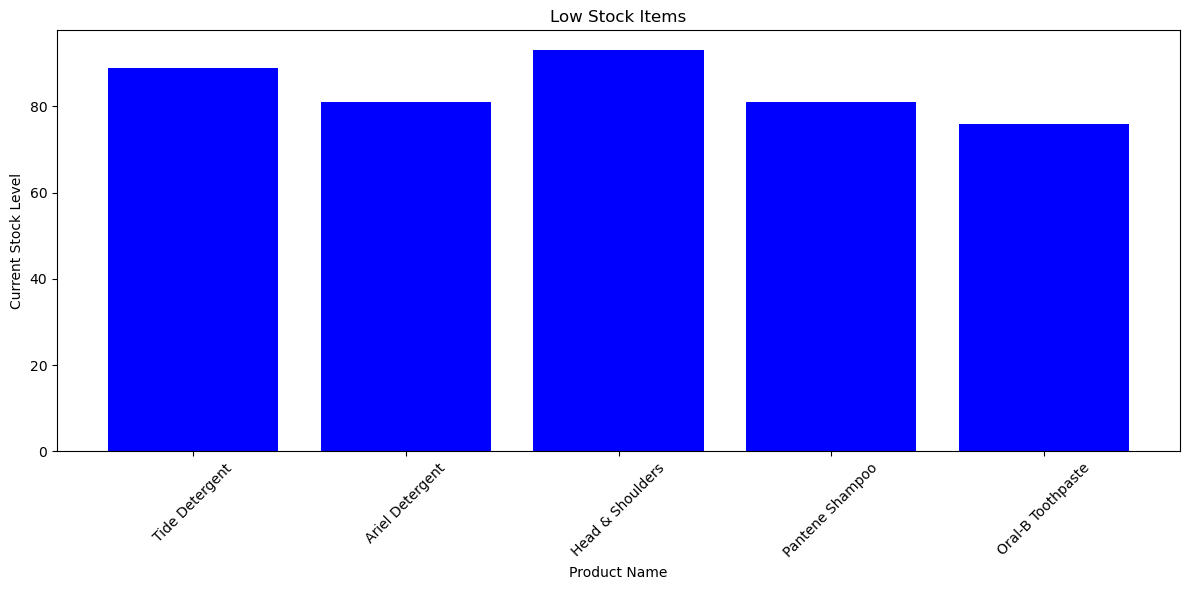

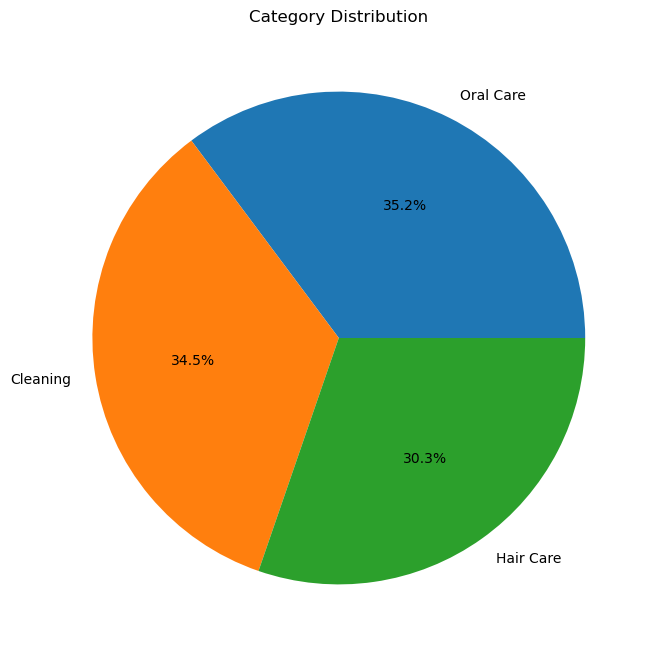

In [6]:
# Bar chart for low stock items
plt.figure(figsize=(12, 6))
plt.bar(low_stock_items["Product_Name"], low_stock_items["Current_Stock_Level"], color="blue")
plt.title("Low Stock Items")
plt.xlabel("Product Name")
plt.ylabel("Current Stock Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie chart for category distribution
category_counts = low_stock_items["Category"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct="%1.1f%%"
)
plt.title("Category Distribution")
plt.show()


## Conclusion

This notebook demonstrates:
- Cleaning and preparing raw inventory data
- Storing and querying data using SQLite
- Analyzing and visualizing inventory insights

The results can be used to make informed decisions about stock management and reordering.
